## 介绍 Introduction

这个笔记是非常基础和简单的介绍融合模型的入门方式，特别是堆叠融合的变体。简而言之，堆叠用作第一级（基础），一些基本的机器学习模型（分类器）的预测，然后在第二级使用另一个模型来预测早期一级预测的输出。

This notebook is a very basic and simple introductory primer to the method of ensembling models, in particular the variant of ensembling known as Stacking. In a nutshell stacking uses as a first-level (base), the predictions of a few basic machine learning models (classifiers) and then uses another model at the second-level to predict the output from the earlier first-level predictions.

泰坦尼克号数据集是引入这一概念的主要方案，许多新手到Kaggle是从这里开始的。此外，即使堆叠技术已经为许多团队在Kaggle比赛获胜的方案，似乎在这个话题上缺少核心，所以我希望这款笔记本可以填补一些空白。

The Titanic dataset is a prime candidate for introducing this concept as many newcomers to Kaggle start out here. Furthermore even though stacking has been responsible for many a team winning Kaggle competitions there seems to be a dearth of kernels on this topic so I hope this notebook can fill somewhat of that void.

我自己也是Kaggle的新手，我设法学习的第一个合适的融合/堆叠脚本是由伟大的Faron在AllState Severity索赔比赛中写的。这笔记的教材大量借鉴了Faron的脚本，尽管我们是融合分类，他的是融合回归方案。但无论如何，请在这里查看他的脚本：

I myself am quite a newcomer to the Kaggle scene as well and the first proper ensembling/stacking script that I managed to chance upon and study was one written in the AllState Severity Claims competition by the great Faron. The material in this notebook borrows heavily from Faron's script although ported to factor in ensembles of classifiers whilst his was ensembles of regressors. Anyway please check out his script here:

[Stacking Starter](https://www.kaggle.com/mmueller/allstate-claims-severity/stacking-starter/run/390867) : by Faron

现在在笔记本上我希望它能以一种直观和简洁的方式，做到公正并且传达出融合的概念。我的另一个独立的Kaggle脚本实现了完全相同的组合步骤（尽管有不同的参数），下面讨论的公共LB分数为0.808，这足以达到前9％，运行时间不到4分钟。 因此，我很确定有很多改进的空间，并添加到该脚本。 无论如何，请随时给我留下任何关于我如何改善的意见

Now onto the notebook at hand and I hope that it manages to do justice and convey the concept of ensembling in an intuitive and concise manner. My other standalone Kaggle [script](https://www.kaggle.com/arthurtok/titanic/simple-stacking-with-xgboost-0-808) which implements exactly the same ensembling steps (albeit with different parameters) discussed below gives a Public LB score of 0.808 which is good enough to get to the top 9% and runs just under 4 minutes. Therefore I am pretty sure there is a lot of room to improve and add on to that script. Anyways please feel free to leave me any comments with regards to how I can improve

In [98]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import KFold;

## 特征探索，工程和清洁 Feature Exploration, Engineering and Cleaning

现在我们将进行常规的工作，就像大多数要点的结构一样，首先是探索手头的数据，找出可能的特征工程，以及对任何分类特征进行数字编码。

Now we will proceed much like how most kernels in general are structured, and that is to first explore the data on hand, identify possible feature engineering opportunities as well as numerically encode any categorical features.

In [99]:
# Load in the train and test datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

In [100]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


毫无疑问，我们的任务是以某种方式从分类变量中提取信息。

Well it is no surprise that our task is to somehow extract the information out of the categorical variables

**特征工程**

**Feature Engineering**

在这里，必须扩展到Sina的特征工程理念，这是非常全面和周全的笔记，所以请看看他的工作

Here, credit must be extended to Sina's very comprehensive and well-thought out notebook for the feature engineering ideas so please check out his work

[Titanic Best Working Classfier](https://www.kaggle.com/sinakhorami/titanic/titanic-best-working-classifier): by Sina

In [101]:
full_data = [train, test]

# Some features of my own that I have added in
# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Feature engineering steps taken from Sina
# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] ;

In [102]:
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,CategoricalFare,CategoricalAge,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,1,1,0,A/5 21171,0,NaN,0,23,0,2,0,"(-0.001, 7.91]","(16.0, 32.0]",1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,PC 17599,3,C85,1,51,1,2,0,"(31.0, 512.329]","(32.0, 48.0]",3


In [140]:
# 特征选择train[["Survived"
# 准备训练和测试数据
from sklearn.feature_selection import SelectKBest,f_classif
print(train.shape)
y = train["Survived"]
print("y.shape",y.shape)

# print(train.shape)
tf_train = train.drop(["Survived"], axis = 1)
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
tf_train = tf_train.drop(drop_elements, axis = 1)
tf_train = tf_train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
print(X_train.shape)
# X_train_ss_new = SelectKBest(f_classif, k=16).fit_transform(X_train, y)
# print(X_train_ss_new.shape)
X_train.head(2)

# X_train.to_csv('./out1.csv')

tf_train_new = SelectKBest(f_classif, k=9).fit_transform(tf_train, y)
# tf_train_new_pd = pd.DataFrame(tf_train_new)
# tf_train_new_pd.to_csv('./out2.csv')
tf_test = test[['Pclass','Sex','Parch','Fare','Embarked','Name_length','Has_Cabin','IsAlone','Title']]
# 独热编码
y = (np.arange(2) == y[:,None]).astype(np.float32)
print("y.shape",y.shape)
print("tf_train_new.shape",tf_train_new.shape)
print("tf_labels.shape",tf_labels.shape)
# 'Pclass','Sex','Parch','Fare','Embarked','Name_length','Has_Cabin','IsAlone','Title'

(891, 19)
y.shape (891,)
(891, 11)
y.shape (891, 2)
tf_train_new.shape (891, 9)
tf_labels.shape (418, 9)


In [111]:
print(tf_labels.shape)
print(type(tf_labels))
tf_labels.head(5)

(418, 9)
<class 'pandas.core.frame.DataFrame'>


,Pclass,Sex,Parch,Fare,Embarked,Name_length,Has_Cabin,IsAlone,Title
0,3,1,0,0,2,16,0,1,1
1,3,0,0,0,0,32,0,0,3
2,2,1,0,1,2,25,0,1,1
3,3,1,0,1,0,16,0,1,1
4,3,0,1,1,0,44,0,0,3


In [59]:
# 特征选择
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

(891, 19)
<class 'pandas.core.frame.DataFrame'>
(891, 12)
<class 'pandas.core.frame.DataFrame'>


好了，现在我们已经清理了这些特性并提取了相关的信息并删除了分类列，现在我们的特性现在应该是数字的，这种格式适合于我们的机器学习模型。

All right so now having cleaned the features and extracted relevant information and dropped the categorical columns our features should now all be numeric, a format suitable to feed into our Machine Learning models. 

然而，在进行之前，让我们生成一些简单的相关和分布图，以转换我们的数据集来观察

However before we proceed let us generate some simple correlation and distribution plots of our transformed dataset to observe ho

## Visualisations

In [40]:
train.head(3)

print(train.shape)

(891, 12)


### 皮尔逊相关热图（Pearson Correlation Heatmap）

让我们产生一些特征的相关图，看看下一个特征是如何相关的。为了做到这一点，我们将利用Seaborn绘图软件，让我们很方便地绘制热图，如下所示

let us generate some correlation plots of the features to see how related one feature is to the next. To do so, we will utilise the Seaborn plotting package which allows us to plot heatmaps very conveniently as follows

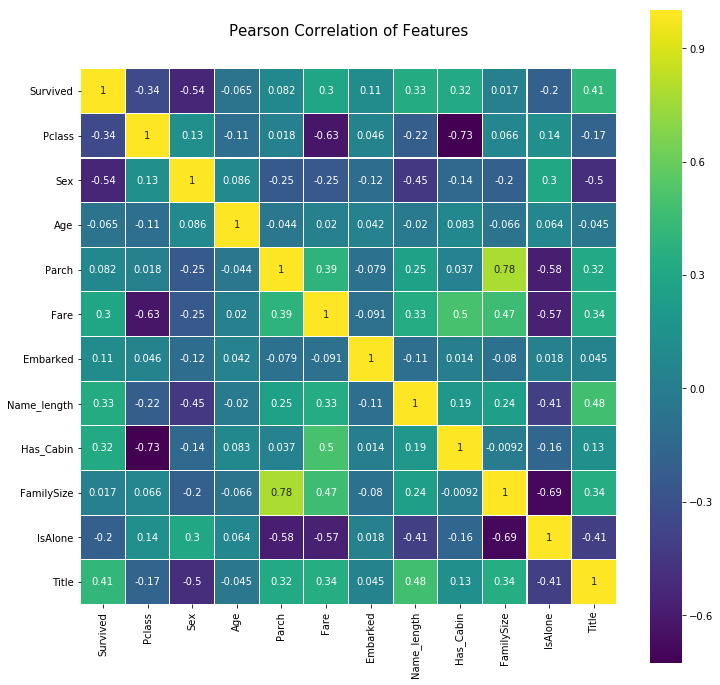

In [41]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

**Takeaway from the Plots**

皮尔森相关图可以告诉我们的一点是，特征之间没有太多的强关联。

One thing that that the Pearson Correlation plot can tell us is that there are not too many features strongly correlated with one another.

这对我们的模型来说是一个好消息，因为这意味着训练数据中没有太多的冗余信息，我们每一个特征都可以提供一个独立的信息

This is good from a point of view of feeding these features into your learning model because this means that there isn't much redundant or superfluous data in our training set and we are happy that each feature carries with it some unique information. 

这两个最相关的特征是家庭大小和父母（父母和孩子）的特征。

Here are two most correlated features are that of Family size and Parch (Parents and Children). 

为了本练习的目的，我仍然会留下这两个功能

I'll still leave both features in for the purposes of this exercise.

**配对图 Pair plots**

最后，我们生成一些配对图来观察数据从一个特征到另一个特征的分布。再次，我们用Seaborn帮助我们。

Finally let us generate some pairplots to observe the distribution of data from one feature to the other. Once again we use Seaborn to help us.

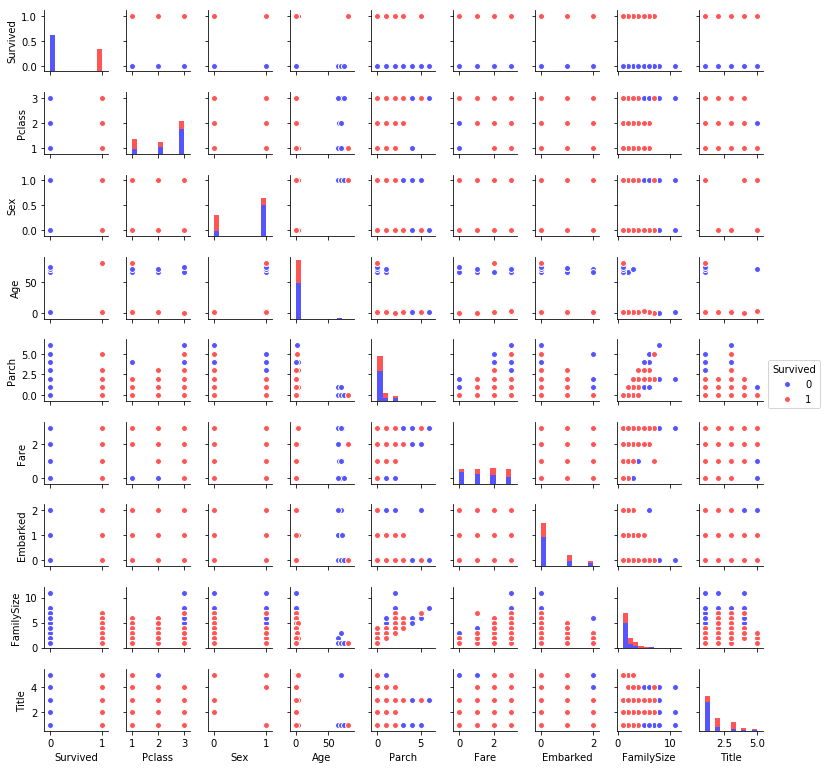

In [42]:
g = sns.pairplot(train[["Survived", "Pclass", "Sex", "Age", "Parch", "Fare", "Embarked","FamilySize", "Title"]],
hue="Survived", palette = "seismic",size=1.2 )


## 融合和堆叠模型 Ensembling & Stacking models

最后在特征工程和格式数据的简要介绍之后，我们终于到了这笔记本的重点部分

Finally after that brief whirlwind detour with regards to feature engineering and formatting, we finally arrive at the meat and gist of the this notebook.

创建堆叠融合

Creating a Stacking ensemble

#### Helpers via Python Classes

在这里, 我们使用 python 类来帮助我们。

Here we invoke the use of Python's classes to help make it more convenient for us. 

对于任何编程新手，通常会听到类和面向对象编程（OOP）一起使用

For any newcomers to programming, one normally hears Classes being used in conjunction with Object-Oriented Programming (OOP). 

简而言之, 一个类帮助扩展一些代码/程序来创建对象 (变量发出老派的嘀咕声), 以及实现特定于该类的函数和方法。

In short, a class helps to extend some code/program for creating objects (variables for old-school peeps) as well as to implement functions and methods specific to that class.

在下面的代码部分，我们写了一个基本类 SklearnHelper ，那允许扩展所有的 Sklearn类的普通方法

In the section of code below, we essentially write a class SklearnHelper that allows one to extend the inbuilt methods (such as train, predict and fit) common to all the Sklearn classifiers. 

因此，如果我们想调用五个不同的分类器，那么这就减少了冗余，因为不需要编写五次相同的方法。

Therefore this cuts out redundancy as won't need to write the same methods five times if we wanted to invoke five different classifiers.

In [43]:
# Some useful parameters which will come in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

# Class to extend XGboost classifer

对于那些已经知道这个但对于之前没有在Python中创建类或对象的人来说，与我一起来，让我解释一下上面给出的代码。

Bear with me for those who already know this but for people who have not created classes or objects in Python before, let me explain what the code given above does. 

在创建我的基类分类器时，我将只使用已经存在于Sklearn库中的模型，因此只能扩展类。

In creating my base classifiers, I will only use the models already present in the Sklearn library and therefore only extend the class for that.

**def init** : Python standard for invoking the default constructor for the class. This means that when you want to create an object (classifier), you have to give it the parameters of clf (what sklearn classifier you want), seed (random seed) and params (parameters for the classifiers).

The rest of the code are simply methods of the class which simply call the corresponding methods already existing within the sklearn classifiers.

### Out-of-Fold Predictions

现在如前面介绍部分所述，堆叠使用基础分类器的预测作为二级模型训练的输入。

Now as alluded to above in the introductory section, stacking uses predictions of base classifiers as input for training to a second-level model.

然而, 你不能简单地在完整的训练数据上训练基本模型, 在完整的测试集上生成预测, 然后将它们输出到二级训练中。

However one cannot simply train the base models on the full training data, generate predictions on the full test set and then output these for the second-level training.

这样做可能会导致您的基本模型预测已经具有“看到”测试集，因此在馈送这些预测时过度拟合。

This runs the risk of your base model predictions already having "seen" the test set and therefore overfitting when feeding these predictions.

In [44]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

## Generating our Base First-Level Models

所以现在让我们准备五个学习模型作为我们的一级分类。 这些型号都可以通过Sklearn库方便地调用，并列出如下：

So now let us prepare five learning models as our first level classification. These models can all be conveniently invoked via the Sklearn library and are listed as follows:
1. Random Forest classifier
2. Extra Trees classifier
3. AdaBoost classifer
4. Gradient Boosting classifer
5. Support Vector Machine

#### Parameters

Just a quick summary of the parameters that we will be listing here for completeness,

**n_jobs** : 用于训练过程的核心数。 如果设置为-1，则使用所有内核。

**n_jobs** : Number of cores used for the training process. If set to -1, all cores are used.

**n_estimators** : 学习模型中的分类树数（默认设置为10）

**n_estimators** : Number of classification trees in your learning model ( set to 10 per default)

**max_depth** : 树的最大深度，或者应该展开多少节点。 如果设置得太高，请注意，会有过拟合的风险

**max_depth** : Maximum depth of tree, or how much a node should be expanded. Beware if set to too high a number would run the risk of overfitting as one would be growing the tree too deep

**verbose** :控制是否在学习过程中输出任何文本。 0将禁止所有文本，而3将在每次迭代时输出树学习过程。

**verbose** : Controls whether you want to output any text during the learning process. A value of 0 suppresses all text while a value of 3 outputs the tree learning process at every iteration.

请通过官方Sklearn网站查看完整说明。 在那里你会发现有一大堆其他有用的参数，你可以玩。

Please check out the full description via the official Sklearn website. There you will find that there are a whole host of other useful parameters that you can play around with.

In [45]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

此外，由于在OOP框架中提到了Object和类，现在让我们通过我们前面定义的Helper Sklearn类创建5个代表我们5个学习模型的对象。

Furthermore, since having mentioned about Objects and classes within the OOP framework, let us now create 5 objects that represent our 5 learning models via our Helper Sklearn Class we defined earlier.

In [46]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

**从我们的训练集和测试集生成NumPy数组**

**Creating NumPy arrays out of our train and test sets**

我们已经准备好了我们的第一层基础模型, 现在我们可以通过从原始 dataframes 中生成 NumPy 阵列, 输入到我们的分类器中准备培训和测试数据, 如下所示:

Great. Having prepared our first layer base models as such, we can now ready the training and test test data for input into our classifiers by generating NumPy arrays out of their original dataframes as follows:

In [47]:
# 用训练，测试，目标创建的Numpy数组提供给模型
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creats an array of the test data

print(x_train.shape)
print(train.shape)
print(type(x_train.shape))
print(type(train.shape))

(891, 11)
(891, 11)
<class 'tuple'>
<class 'tuple'>


**第一级预测输出**
**Output of the First level Predictions**

我们现在提供训练和测试数据集输入到我们的5歌基本分类器中，并使用我们先前定义的 Out-of-Fold 预测函数来生成我们的第一级预测

We now feed the training and test data into our 5 base classifiers and use the Out-of-Fold prediction function we defined earlier to generate our first level predictions. 

允许用几分钟时间来运行下面的代码块

Allow a handful of minutes for the chunk of code below to run.

In [15]:
# 创建我们训练和测试与测试，这些基本结果将会用于新的特征
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("训练完成")

训练完成


**从不同的分类器产生特征重要度**

**Feature importances generated from the different classifiers**

现在我们学了了第一级分类器，我们能用非常简单的代码在训练和测试数据集上利用Sklearn的模型作出非常漂亮的特征  

Now having learned our the first-level classifiers, we can utilise a very nifty feature of the Sklearn models and that is to output the importances of the various features in the training and test sets with one very simple line of code.

按照Sklearn文档，大多数分类器是通过简单的输入的返回来构建特征重要度

As per the Sklearn documentation, most of the classifiers are built in with an attribute which returns feature importances by simply typing in .

特种的重要性，因此我们将调用这个非常有用的属性通过我们之前的函数来绘制这个重要的特征

feature importances. Therefore we will invoke this very useful attribute via our function early plot the feature importances as such

In [16]:
rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)

[ 0.12592943  0.19760582  0.03007977  0.02070044  0.07178036  0.02381778
  0.10723526  0.06432891  0.06892255  0.01331678  0.27628289]
[ 0.11964218  0.37983173  0.02155922  0.01671276  0.05560539  0.02746714
  0.0461332   0.08463123  0.04626845  0.02161751  0.18053119]
[ 0.032  0.01   0.02   0.066  0.038  0.008  0.688  0.014  0.048  0.006
  0.07 ]
[ 0.07268829  0.04123078  0.09532399  0.02892206  0.10707462  0.04536628
  0.4076376   0.01643185  0.07257703  0.02507157  0.08767592]


所以我还不知道怎么分配和存储这些特征重要度

So I have not yet figured out how to assign and store the feature importances outright. 

因此，我将从上面的代码中打印出值，然后简单地复制粘贴到Python列表中，如下所示

Therefore I'll print out the values from the code above and then simply copy and paste into Python lists as below

In [17]:
rf_features = [0.10474135,  0.21837029,  0.04432652,  0.02249159,  0.05432591,  0.02854371
  ,0.07570305,  0.01088129 , 0.24247496,  0.13685733 , 0.06128402]
et_features = [ 0.12165657,  0.37098307  ,0.03129623 , 0.01591611 , 0.05525811 , 0.028157
  ,0.04589793 , 0.02030357 , 0.17289562 , 0.04853517,  0.08910063]
ada_features = [0.028 ,   0.008  ,      0.012   ,     0.05866667,   0.032 ,       0.008
  ,0.04666667 ,  0.     ,      0.05733333,   0.73866667,   0.01066667]
gb_features = [ 0.06796144 , 0.03889349 , 0.07237845 , 0.02628645 , 0.11194395,  0.04778854
  ,0.05965792 , 0.02774745,  0.07462718,  0.4593142 ,  0.01340093]

从一个包含特征重要度特征重要度数据来创造一个数据集，以便通过Plotly包绘图

Create a dataframe from the lists containing the feature importance data for easy plotting via the Plotly package.

In [18]:
cols = train.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })

**特征重要度通过Plotly 散点图来交互**

**Interactive feature importances via Plotly scatterplots**

在这种情况下，为将使用交互式Plotly包来显示不同分类器的特征重要度

I'll use the interactive Plotly package at this juncture to visualise the feature importances values of the different classifiers

In [19]:
# 散点图 
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= '随机森林特征重要度',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= '特征重要度',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Extra Trees  feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Extra Trees  feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= '特征重要度',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= '特征重要度',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'AdaBoost',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

现在让我们计算所有特征重要度的平均值和存储它到新列到特征重要度数据集

Now let us calculate the mean of all the feature importances and store it as a new column in the feature importance dataframe

In [20]:
# 创建包含平均值的新列
# Create the new column containing the average of values

feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1表示操作横轴 computes the mean row-wise
feature_dataframe.head(3)

,AdaBoost feature importances,Extra Trees feature importances,Gradient Boost feature importances,Random Forest feature importances,features,mean
0,0.028,0.121657,0.067961,0.104741,Pclass,0.080590
1,0.008,0.370983,0.038893,0.218370,Sex,0.159062
2,0.012,0.031296,0.072378,0.044327,Age,0.040000


**绘制平均特征重要度的条形图

**lotly Barplot of Average Feature Importances**

在所有分类器中获得平均特征重要度之后，我们可以将它们绘制成如下的绘图条形图：

Having obtained the mean feature importance across all our classifiers, we can plot them into a Plotly bar plot as follows:

In [33]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= '特征重要度条形平均值',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= '特征重要度',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')
print("data.shape",data.shape)

AttributeError: 'list' object has no attribute 'shape'

### 从一集预测产生二级预测  Second-Level Predictions from the First-level Output¶

**一级输出作为新特征**

**First-level output as new features**

现在我们获得了一级预测，可以认为它基本上构建了一组新的特征，用作下一个分类器的训练数据。

Having now obtained our first-level predictions, one can think of it as essentially building a new set of features to be used as training data for the next classifier.

按照下面的代码，我们因此将新列一级预测作为早期分类器并对下一级分类

As per the code below, we are therefore having as our new columns the first-level predictions from our earlier classifiers and we train the next classifier on this.

In [22]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

,AdaBoost,ExtraTrees,GradientBoost,RandomForest
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


**从二级训练数据集绘制热图相关性**

**Correlation Heatmap of the Second Level Training set**

In [23]:
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Portland',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

有很多文章和Kaggle的竞赛冠军的故事都是关于有训练的模型的优点，它们之间的联系越不紧密，就越能产生更好的分数。

There have been quite a few articles and Kaggle competition winner stories about the merits of having trained models that are more uncorrelated with one another producing better scores.

In [24]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

现在连接和加入第一级训练和测试预测集是x_train和x_test，我们现在能放入第二级训练模型

Having now concatenated and joined both the first-level train and test predictions as x_train and x_test, we can now fit a second-level learning model.

### Second level learning model via XGBoost

现在我们选择非常著名的XGBoost库来提高树形学习模型，XGBoost.

Here we choose the extremely famous library for boosted tree learning model, XGBoost. 

它是为了优化大规模树算法而建立

It was built to optimize large-scale boosted tree algorithms. 

有关算法的更多信息，请查看官方文档。

For further information about the algorithm, check out the official documentation.

无论如何，我们叫他XGB分类器并将其用于第一级训练和目标数据并用于学习模型在如下预测测试数据

Anyways, we call an XGBClassifier and fit it to the first-level train and target data and use the learned model to predict the test data as follows:

In [25]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

只需快速运行模型中使用的XGBoost参数

Just a quick run down of the XGBoost parameters used in the model:

**最大深度** : 深度决定了你的树。小心，如果设置过高的值可能引起过拟合

**max_depth** : How deep you want to grow your tree. Beware if set to too high a number might run the risk of overfitting.

**伽马** 在树的叶节点进一步分区需要降低最小损失，越大，算法就越保守

**gamma** : minimum loss reduction required to make a further partition on a leaf node of the tree. The larger, the more conservative the algorithm will be.

**步长** : 步长收缩程度用于促进每一步并防止过拟合

**eta** : step size shrinkage used in each boosting step to prevent overfitting

**生成提交文件**

**Producing the Submission file**

最后训练和适应我们所有的一级和二级模型，我们现在可以输出这个预测文件来提交到泰坦尼克比赛

Finally having trained and fit all our first-level and second-level models, we can now output the predictions into the proper format for submission to the Titanic competition as follows:

In [26]:
# Generate Submission File 
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
StackingSubmission.to_csv("StackingSubmission.csv", index=False)

**进一步改善的步骤**

**Steps for Further Improvement**

作为结束语，必须注意，上面采取的步骤只是展示了一种非常简单的制作集合堆叠器的方法。

As a closing remark it must be noted that the steps taken above just show a very simple way of producing an ensemble stacker. 

你了解到的融合创造了高级别的Kaggle比赛，必然结合了堆叠分类器，其中包括堆叠分类器的混合组合以及层叠级别超过2级。

You hear of ensembles created at the highest level of Kaggle competitions which involves monstrous combinations of stacked classifiers as well as levels of stacking which go to more than 2 levels.

为了提高分数可能需要采取一些额外的步骤

Some additional steps that may be taken to improve one's score could be:

1. 在训练模型中实现良好的交叉验证策略，以找到最佳参数值
2. 为学习引入更多的基础模型。结果越不相关，最终得分就越好。

1. Implementing a good cross-validation strategy in training the models to find optimal parameter values
2. Introduce a greater variety of base models for learning. The more uncorrelated the results, the better the final score.

### 结论 Conclusion

我在这个笔记本有助于在引入堆叠学习模型的工作脚本。再次允许Faron and Sina扩张

I have this notebook has been helpful somewhat in introducing a working script for stacking learning models. Again credit must be extended to Faron and Sina.

对于其他一般的堆叠或合奏的优秀材料，请参阅“MLWave：Kaggle Ensembling Guide”网站上的事实上必读的文章。

For other excellent material on stacking or ensembling in general, refer to the de-facto Must read article on the website MLWave: Kaggle Ensembling Guide.

指导下一次，再见

Till next time, Peace Out

In [27]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import tensorflow as tf

from sklearn import model_selection
# settings
LEARNING_RATE = 1e-4
# set to 20000 on local environment to get 0.99 accuracy
TRAINING_ITERATIONS = 25       
    
DROPOUT = 0.5
BATCH_SIZE = 50

# set to 0 to train on all available data
VALIDATION_SIZE = 2000

# image number to output
IMAGE_TO_DISPLAY = 10

In [149]:
# 计算精准度
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])
# 保存结果
def savecsv(test_prediction_np, filename="submission_tf_titanic.csv"):
#     np.savetxt('submission_tf_titanic.csv', 
#            np.c_[range(1,len(x_test)+1),test_prediction_np], 
#            delimiter=',', 
#            header = 'PassengerId,Survived', 
#            comments = '', 
#            fmt='%d')
    StackingSubmission = pd.DataFrame({'PassengerId': PassengerId,'Survived': test_prediction_np })
    StackingSubmission.to_csv(filename, index=False)

In [29]:
print(x_train.shape)
print(y_train.shape)
print(train.shape)

(891, 5)
(891,)
(891, 11)


In [30]:
# 独热编码
y_train = (np.arange(2) == y_train[:,None]).astype(np.float32)
print(y_train.shape)

(891, 2)


In [169]:
#形成验证数据
train_dataset, valid_dataset = model_selection.train_test_split(tf_train, test_size=0.3, random_state=0)
train_labels, valid_labels = model_selection.train_test_split(y, test_size=0.3, random_state=0)
print(train_dataset.shape)
print(valid_dataset.shape)
print(train_labels.shape)
print(valid_labels.shape)

(623, 11)
(268, 11)
(623, 2)
(268, 2)


In [164]:
# 根据tf任务3.1加入l2 0.77990
# 加入DropOut 0.78947
# 加入梯度学习率，原学习率0.5  0.78469
# 加入5层隐藏层 0.78469
# 减少到3层，初始化节点减小到256

batch_size = 64  
regularation_param = 0.0001  
keep_prob = 0.8
graph = tf.Graph()  
num_labels = 2
hidden_nodes = 512

print(train_dataset.shape)

def compute_logits(data, weightss, biasess, dropout_vals=None):  
    temp = data  
    if dropout_vals:  
        for w,b,d in zip(weightss[:-1], biasess[:-1], dropout_vals[:-1]):  
            temp = tf.nn.relu_layer(tf.nn.dropout(temp, d), w, b)  
        temp = tf.matmul(temp, weightss[-1]) + biasess[-1]  
    else:  
        for w,b in zip(weightss[:-1], biasess[:-1]):  
            temp = tf.nn.relu_layer(temp, w, b)  
        temp = tf.matmul(temp, weightss[-1]) + biasess[-1]  
    return temp

with graph.as_default():
    # -----------------------------------------1
    # 输入 
    # placeholder 插入一个待初始化的张量占位符
    # 重要事项：这个张量被求值时会产生错误。 
    # 它的值必须在Session.run(), Tensor.eval() 或 Operation.run() 中使用feed_dict的这个可选参数来填充。
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, train_dataset.shape[1]))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    
    # 创建一个常量张量
    # tf_valid_dataset = Tensor("Const:0", shape=(10000, 784), dtype=float32)
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(x_test)
    
    #转数据类型，f64->f32
    tf_train_dataset = tf.to_float(tf_train_dataset)
    tf_valid_dataset = tf.to_float(tf_valid_dataset)
    tf_test_dataset = tf.to_float(tf_test_dataset)
    
    # 变量
    # 梯度学习率
    # 初始的学习速率
    starter_learning_rate = 0.03 
    # 全局的step，与 decay_step 和 decay_rate一起决定了 learning rate的变化
    global_step = tf.Variable(0, trainable=False)
    # 衰减速度
    decay_steps = 50
    # 衰减系数
    decay_rate = 0.8
    # 如果staircase=True，那就表明每decay_steps次计算学习速率变化，更新原始学习速率.
    # 如果是False，那就是每一步都更新学习速率
    staircase = False
    # 指数衰减:法通过这个函数，可以先使用较大的学习率来快速得到一个比较优的解，然后随着迭代的继续逐步减小学习率，使得模型在训练后期更加稳定
    # 87.7% 仅仅指数衰减
    learning_rate = tf.train.exponential_decay(starter_learning_rate,global_step,decay_steps,decay_rate,staircase)
    
    
    # 当你训练一个模型的时候，你使用变量去保存和更新参数。
    # 在Tensorflow中变量是内存缓冲区中保存的张量（tensor）
    
    # 第一层
    # truncated_normal 从一个正态分布片段中输出随机数值,
    # 生成的值会遵循一个指定了平均值和标准差的正态分布，只保留两个标准差以内的值，超出的值会被弃掉重新生成。
    # 返回 一个指定形状并用正态分布片段的随机值填充的张量
    # 数字平方根
    x = 2.0
    weights1 = tf.Variable(tf.truncated_normal([train_dataset.shape[1], hidden_nodes], stddev = np.sqrt(x / hidden_nodes)))
    biases1 = tf.Variable(tf.zeros([hidden_nodes]))
    
    # 第二层
    weights2 = tf.Variable(tf.truncated_normal([hidden_nodes, int(hidden_nodes / 2)], stddev = np.sqrt(x / hidden_nodes / 2)))
    biases2 = tf.Variable(tf.zeros([hidden_nodes / 2]))
    hidden_nodes = int(hidden_nodes / 2)
    
    # 第三层
    weights3 = tf.Variable(tf.truncated_normal([hidden_nodes, int(hidden_nodes / 2)], stddev = np.sqrt(x / hidden_nodes / 2)))
    biases3 = tf.Variable(tf.zeros([hidden_nodes / 2]))
    hidden_nodes = int(hidden_nodes / 2)
    
    # 第四层 94.5
    weights4 = tf.Variable(tf.truncated_normal([hidden_nodes, int(hidden_nodes / 2)], stddev = np.sqrt(x / hidden_nodes / 2)))
    biases4 = tf.Variable(tf.zeros([hidden_nodes / 2]))
    hidden_nodes = int(hidden_nodes / 2)
    
    # 第五层 94.5
    weights5 = tf.Variable(tf.truncated_normal([hidden_nodes, int(hidden_nodes / 2)], stddev = np.sqrt(x / hidden_nodes / 2)))
    biases5 = tf.Variable(tf.zeros([hidden_nodes / 2]))
    hidden_nodes = int(hidden_nodes / 2)
    
    
    weights_end = tf.Variable(tf.truncated_normal([hidden_nodes, num_labels]))
    biases_end = tf.Variable(tf.zeros([num_labels]))
    
    print("weights_end.shape", weights_end.shape)
    print("biases_end.shape", biases_end.shape)
    print(train_dataset.shape)
    
    #DropOut
    drop = tf.nn.dropout(tf_train_dataset, keep_prob=keep_prob)
    
    # 训练计算.
#     train_logits = tf.add(tf.matmul(drop, weights), biases)
#     valid_logits = tf.add(tf.matmul(tf_valid_dataset, weights), biases)
#     test_logits = tf.add(tf.matmul(tf_test_dataset, weights), biases)
    train_logits = compute_logits(tf_train_dataset, [weights1, weights2, weights3, weights4, weights5, weights_end], 
                            [biases1,biases2,biases3,biases4,biases5, biases_end],  
                            dropout_vals=(1.0,1,1,1,1,1.0))
    valid_logits = compute_logits(tf_valid_dataset, [weights1, weights2, weights3, weights4, weights5, weights_end], 
                          [biases1,biases2,biases3,biases4,biases5, biases_end])
    test_logits = compute_logits(tf_test_dataset, [weights1, weights2, weights3, weights4, weights5, weights_end], 
                          [biases1,biases2,biases3,biases4,biases5, biases_end])
    
    
    #加l2_loss
    hpl2 =  regularation_param * (tf.nn.l2_loss(weights1)
                                  + tf.nn.l2_loss(weights2)
                                  + tf.nn.l2_loss(weights3)
                                  + tf.nn.l2_loss(weights4)
                                  + tf.nn.l2_loss(weights5)
                                 )
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=train_logits))
    loss = tf.add(loss, hpl2)


    # 最优化.因为深度学习常见的是对于梯度的优化，也就是说，优化器最后其实就是各种对于梯度下降算法的优化。 
#     optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
    optimizer = tf.train.GradientDescentOptimizer(0.02).minimize(loss, global_step=global_step)
    
    
    train_prediction = tf.nn.softmax(train_logits)
    valid_prediction = tf.nn.softmax(valid_logits)
    test_prediction = tf.nn.softmax(test_logits)
    
    

(623, 11)
weights_end.shape (32, 2)
biases_end.shape (2,)
(623, 11)


In [171]:
num_steps = 10000  
print(type(train_dataset))
print(type(train_labels))
train_dataset_np = train_dataset.values
with tf.Session(graph=graph) as session:  
    tf.global_variables_initializer().run()  
    print("Initialized")  
    for step in range(num_steps):  
        # 在训练数据中选择一个已被随机化的偏移量.
        # 提醒: 我们能使用更好的随机化穿过所有数据.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
#         print(train_dataset.shape)
#         print(train_labels.shape)
        # 生成一个小批量数据
        batch_data = train_dataset_np[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]  
#         print("batch_data.shape",batch_data.shape)
#         print("batch_labels.shape",batch_labels.shape)
        # feed_dict的作用是给使用placeholder创建出来的tensor赋值。
        # 其实，他的作用更加广泛：feed 使用一个 值临时替换一个 op 的输出结果. 
        # 你可以提供 feed 数据作为 run() 调用的参数. feed 只在调用它的方法内有效, 方法结束, feed 就会消失.
        #  传递值到tf的命名空间  
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}  
        summary, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % 500 == 0):  
            print("Minibatch loss at step %d: %f" % (step, l))  
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))  
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))  
            
    # 获取结果，用于保存
    test_prediction_np = test_prediction.eval()
    test_prediction_np = np.argmax(test_prediction_np, 1)
#     print("test_prediction_np.shape",test_prediction_np.shape)
#     print("test_prediction_np",test_prediction_np)
    savecsv(test_prediction_np,"submission_tf_2lnn")


<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
Initialized
Minibatch loss at step 0: 0.728778
Minibatch accuracy: 60.9%
Validation accuracy: 38.4%
Minibatch loss at step 500: 0.465791
Minibatch accuracy: 79.7%
Validation accuracy: 75.4%
Minibatch loss at step 1000: 0.443032
Minibatch accuracy: 82.8%
Validation accuracy: 78.7%
Minibatch loss at step 1500: 0.454384
Minibatch accuracy: 82.8%
Validation accuracy: 78.4%
Minibatch loss at step 2000: 0.454174
Minibatch accuracy: 81.2%
Validation accuracy: 79.1%
Minibatch loss at step 2500: 0.378090
Minibatch accuracy: 84.4%
Validation accuracy: 80.2%
Minibatch loss at step 3000: 0.483790
Minibatch accuracy: 82.8%
Validation accuracy: 79.5%
Minibatch loss at step 3500: 0.359001
Minibatch accuracy: 84.4%
Validation accuracy: 82.1%
Minibatch loss at step 4000: 0.392816
Minibatch accuracy: 90.6%
Validation accuracy: 81.3%
Minibatch loss at step 4500: 0.319389
Minibatch accuracy: 87.5%
Validation accuracy: 80.2%
Minibatch loss at st

KeyboardInterrupt: 

In [113]:

# 变厚矩阵
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


# 偏置
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


# 卷积处理 变厚过程
def conv2d(x, W):
    # stride [1, x_movement, y_movement, 1] x_movement、y_movement就是步长
    # Must have strides[0] = strides[3] = 1 padding='SAME'表示卷积后长宽不变
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


# pool 长宽缩小一倍
def max_pool_2x2(x):
    # stride [1, x_movement, y_movement, 1]
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')


In [162]:
graphCNN = tf.Graph()  

with graphCNN.as_default():
    # define placeholder for inputs to network
    xs = tf.placeholder(tf.float32, [None, 9])  # 原始数据的维度：9
    ys = tf.placeholder(tf.float32, [None, 2])  # 输出数据为维度：2

    keep_prob = tf.placeholder(tf.float32)  # dropout的比例

    x_image = tf.reshape(xs, [-1, 3, 3, 1])  # 原始数据9变成二维图片3*3
    ## conv1 layer ##第一卷积层
    W_conv1 = weight_variable([2, 2, 1, 32])  # patch 2x2, in size 1, out size 32,每个像素变成32个像素，就是变厚的过程
    b_conv1 = bias_variable([32])
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)  # output size 2x2x32，长宽不变，高度为32的三维图像
    # h_pool1 = max_pool_2x2(h_conv1)     # output size 2x2x32 长宽缩小一倍

    ## conv2 layer ##第二卷积层
    W_conv2 = weight_variable([2, 2, 32, 64])  # patch 2x2, in size 32, out size 64
    b_conv2 = bias_variable([64])
    h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2) + b_conv2)  # 输入第一层的处理结果 输出shape 4*4*64

    ## fc1 layer ##  full connection 全连接层
    W_fc1 = weight_variable([3 * 3 * 64, 512])  # 4x4 ，高度为64的三维图片，然后把它拉成512长的一维数组
    b_fc1 = bias_variable([512])

    h_pool2_flat = tf.reshape(h_conv2, [-1, 3 * 3 * 64])  # 把4*4，高度为64的三维图片拉成一维数组 降维处理
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)  # 把数组中扔掉比例为keep_prob的元素
    ## fc2 layer ## full connection
    W_fc2 = weight_variable([512, 2])  # 512长的一维数组压缩为长度为2的数组
    b_fc2 = bias_variable([2])  # 偏置
    # 最后的计算结果
    prediction = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
    # prediction = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
    # 计算 predition与y 差距 所用方法很简单就是用 suare()平方,sum()求和,mean()平均值
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=ys, logits=prediction))
    # 0.01学习效率,minimize(loss)减小loss误差
    train_step = tf.train.AdamOptimizer(0.03).minimize(cross_entropy)

In [163]:
print("tf_train_new.shape",tf_train_new.shape)
print("tf_labels.shape",tf_labels.shape)
print("y.shape",y.shape)

print(type(tf_train_new))
print(type(y))
with tf.Session(graph=graphCNN) as sess:

    # important step
    # tf.initialize_all_variables() no long valid from
    # 2017-03-02 if using tensorflow >= 0.12
    sess.run(tf.global_variables_initializer())
    # 训练500次
    for i in range(2001):

    #     feed_dict_test = {tf_train_dataset : X_test_new_ss}  
    #     feed_dict = {tf_train_dataset : X_tr_tf, tf_train_labels : train_labels, keep_prob_s: keep_prob }  
        sess.run(train_step, feed_dict={xs: tf_train_new, ys: y, keep_prob: 0.7})
        loss = sess.run(cross_entropy, feed_dict={xs: tf_train_new, ys: y, keep_prob: 1.0})
        # 输出loss值
        if (i % 100 == 0): 
            print(i, '误差=',loss)  
    # 可视化
    prediction_value = sess.run(prediction, feed_dict={xs: tf_test, keep_prob: 1.0})
#     print(prediction_value)
    prediction_value = np.argmax(prediction_value, 1)
    print(prediction_value.shape)
    #     print("test_prediction_np",test_prediction_np[0])
    #     print("test_prediction_np.shpe",test_prediction_np.shape)
    #     print("x.shpe",x.shape)
    #     print("x",x)
    #     print("test_prediction_np.shape",test_prediction_np.shape)
    savecsv(prediction_value,"submission_tf_2lcnn")

    print("Complete")

tf_train_new.shape (891, 9)
tf_labels.shape (418, 9)
y.shape (891, 2)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
0 误差= 90.6027
100 误差= 0.493035
200 误差= 0.487853
300 误差= 0.490301
400 误差= 0.487671
500 误差= 0.497718
600 误差= 0.487837
700 误差= 0.491775
800 误差= 0.48758
900 误差= 0.491211
1000 误差= 0.486894
1100 误差= 0.484744
1200 误差= 0.480535


KeyboardInterrupt: 